In [1]:
import numpy as np
from mpmath import polylog
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from networkx import average_shortest_path_length
from scipy.optimize import fsolve

##### Download the data for the LastFM Asia Social Network from http://snap.stanford.edu/data/feather-lastfm-social.html. All you need is the file with edges. Note that node indices start with 0.

In [2]:
edge_list = pd.read_csv('./lastfm_asia_edges.csv').to_numpy()

def load_graph(edge_list):
    num_nodes = edge_list.max() + 1
    graph = [list() for _ in range(num_nodes)]
    for a, b, in edge_list:
        graph[a].append(b)
        graph[b].append(a)
    return graph

graph = load_graph(edge_list)
nx_graph = nx.from_edgelist(edge_list)

##### What is the number of connected components of this network, and what are their sizes?

In [3]:
def dfs(graph, i):
    nodes = [i]
    done = set([i])
    while nodes:
        next_nodes = [n for n in graph[nodes.pop()] if n not in done]
        nodes.extend(next_nodes)
        done = done.union(next_nodes)
    return list(done)

def get_connected_comps(graph):
    all_nodes = set(range(len(graph)))
    comp_sizes = []
    while all_nodes:
        comp = dfs(graph, all_nodes.pop())
        all_nodes = all_nodes.difference(comp)
        comp_sizes.append(len(comp))
    return comp_sizes

comp_sizes = get_connected_comps(graph)
print("The connected component sizes are ", comp_sizes)

The connected component sizes are  [7624]


##### Find the degree distribution for this network. 

In [8]:
degrees = [len(x) for x in graph]
ks, pks = np.unique(degrees , return_counts=True)
pks = pks/np.sum(pks)
print("The degree distribution is :")
pd.DataFrame(np.stack([np.array(ks), np.array(pks)], axis=-1), columns=['k', 'p_k'])

The degree distribution is :


,k,p_k
0,1.0,0.230063
1,2.0,0.155824
2,3.0,0.103751
3,4.0,0.081191
4,5.0,0.060860
...,...,...
93,159.0,0.000131
94,172.0,0.000131
95,174.0,0.000131
96,175.0,0.000131


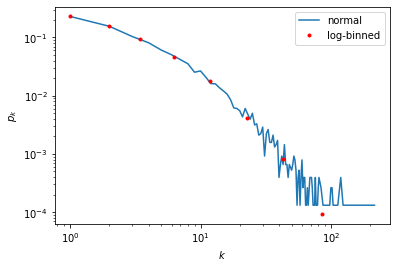

In [11]:
plt.plot(ks, pks, label='normal')

logk_max = int(np.log2(ks[-1])) +1
logk_bins = np.power(2, np.arange(logk_max+1))
bin_indices = [0]
ind = 0
for i,k in enumerate(ks):
    try:
        if k > logk_bins[ind]:
            bin_indices.append(i)
            ind += 1
    except:
        break

ks_logbinned, pks_logbinned = [], []

for i in range(logk_max):
    rel_ks = ks[bin_indices[i]:bin_indices[i+1]]
    rel_pks = pks[bin_indices[i]:bin_indices[i+1]]
    ks_logbinned.append(np.sum(rel_ks*rel_pks)/np.sum(rel_pks))
    pks_logbinned.append(np.sum(rel_pks)/max(2**(i-1), 1))

plt.plot(ks_logbinned, pks_logbinned, 'r.', label='log-binned')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$')
plt.ylabel('$p_k$')
plt.legend()
plt.show()

##### Approximate the log-binning data for the degree distribution with the power-law with exponential cut-off: $p_k = Ce^{-\alpha k}k^{-\tau}$,

###### Taking $\log$ on both sides and rearranging, we have $\log p_k = \log C -\alpha k -\tau \log k$

In [16]:
y = np.log(np.array(pks_logbinned))
x = np.stack((-np.array(ks_logbinned), -np.log(np.array(ks_logbinned)), np.ones(len(y)) ), axis=-1)
(alpha, tau, logc), _, _, _ = np.linalg.lstsq(x, y)
c = np.exp(logc)
print("C:", c, "alpha:", alpha, "tau:", tau)

C: 0.31466594967276845 alpha: 0.044690401295698935 tau: 1.0005675111342802


<ipython-input-16-e48895113290>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (alpha, tau, logc), _, _, _ = np.linalg.lstsq(x, y)


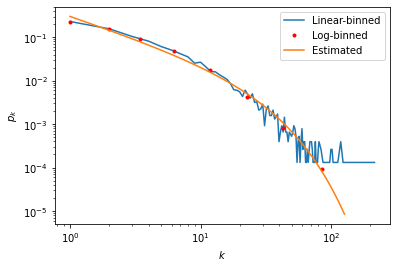

In [17]:
def pk_estimate(k):
    return c*np.exp(-alpha*k)*k**(-tau)

plt.plot(ks, pks, label='Linear-binned')
plt.plot(ks_logbinned, pks_logbinned, 'r.', label='Log-binned')
plt.plot(np.arange(1, 128), pk_estimate(np.arange(1, 128)), label='Estimated')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$')
plt.ylabel('$p_k$')
plt.legend()
plt.savefig('./pk_vs_k.png', bbox_inches='tight')
plt.show()


In [71]:
pks_rand = np.array([pk_estimate(k) for k in range(1,100)])
pks_rand = pks_rand/pks_rand.sum()
def generate_rand_graph(degrees):
    nodes = np.arange(len(degrees))
    num_edges = sum(degrees)/2
    edge_list = set([])
    while num_edges > 0:
        edge = tuple(np.random.choice(nodes, replace=False, p=degrees/(2*num_edges), size=2))
        #print(num_edges, len(edge_list))
        if edge in edge_list:
            continue
        edge_list.add(edge)
        degrees[edge[0]] -= 1
        degrees[edge[1]] -= 1
        assert degrees[edge[0]] >= 0
        num_edges -= 1
    return edge_list
print(len(graph))
degrees = np.random.choice(np.arange(1, 100), p=pks_rand, size=len(graph))
assert sum(degrees)%2 == 0
rand_edge_list = list(generate_rand_graph(degrees))

# rand_graph = load_graph(np.array(rand_edge_list))
# rand_nx_graph = nx.from_edgelist(rand_edge_list)
# largest_cc = rand_nx_graph.subgraph(max(nx.connected_components(rand_nx_graph), key=len)).copy()
# print(len(largest_cc.nodes()))
# rand_aspl = average_shortest_path_length(largest_cc)

# print(rand_aspl)
# print(clustering_coefficient(rand_graph))
# print(np.mean([d for _, d in largest_cc.degree()]))
# print(np.mean([d**2 for _, d in largest_cc.degree()]) - np.mean([d for _, d in largest_cc.degree()]))

# nodes = largest_cc.nodes()
# ls = []
# for _ in range(1000):
#     n, m = np.random.choice(nodes, size=2)
#     ls.append(nx.shortest_path_length(largest_cc, source = n, target = m))
# print(np.mean(ls))

7624


##### Find the average shortest-path length in the actual network and compare with estimated average shortest-path length for the random graph 

In [19]:
aspl = average_shortest_path_length(nx_graph)

z1 = float(polylog(tau-1, np.exp(-alpha))/polylog(tau, np.exp(-alpha)))
z2 = float((polylog(tau-2, np.exp(-alpha)) - polylog(tau-1, np.exp(-alpha)))/polylog(tau, np.exp(-alpha)))
N = len(graph)
# z1 = 6.821790090570059
# z2 = 136.4714970697922
# N = len(largest_cc.nodes())
l1 = 1 + (np.log(N) - np.log(z1))/np.log(z2/z1)
l2 = (np.log((N-1)*(z2 - z1) + z1*z1) - np.log(z1*z1))/(np.log(z2/z1))

print("Actual avg shortest path length:", aspl)
print("Avg shortest path length in a random graph:", l2)

Actual avg shortest path length: 5.232237268915701
Avg shortest path length in a random graph: 3.2523238375334174


##### Find the clustering coefficient of the network

In [20]:
def clustering_coefficient(graph):
    num_triangles = 0
    total = 0
    for i in range(len(graph)):
        for jind, j in enumerate(graph[i]):
            for k in graph[i][:jind]:
                if k in graph[j]:
                    num_triangles += 1
                total += 1
    return num_triangles/total

print("Estimated clustering coefficient for actual graph is ", clustering_coefficient(graph))

print("Estimated clustering coefficient for random graph is ",(z2)**2/(N*z1**3))

Estimated clustering coefficient for actual graph is  0.178622548153384
Estimated clustering coefficient for random graph is  0.008980857062451263


##### What is the critical transmissibility $T_c$ of the actual graph? 

In [21]:
k = np.mean([len(x) for x in graph])
k2 = np.mean([len(x)**2 for x in graph])
print("Critical transmissibility is", k/(k2 - k))

Critical transmissibility is 0.04094657477764034


##### Run the SIR model on the actual network with $T = 0.4$

In [76]:
all_runs = []
T = 0.1
V = 0#1 - (k/(k2 - k))/0.4 
# T = T*(1-V)
# V=0
for _ in range(10):
    trans_edge_inds = np.random.choice(np.arange(len(rand_edge_list)), size=int(T*len(rand_edge_list)), replace=False)
    vacc_nodes = np.random.choice(np.arange(N), size=int(V*N), replace=False)
    trans_edge_list = np.array([(a,b) for a,b in np.array(rand_edge_list)[trans_edge_inds] if a not in vacc_nodes and b not in vacc_nodes])
    trans_graph = load_graph(trans_edge_list)
    valid_nodes = [i for i in range(len(trans_graph)) if trans_graph[i]]

    start_node = np.random.choice(valid_nodes)
    infected = [start_node]
    recovered = []

    num_infected = []
    for i in range(20):
        next_infected = []
        for node in infected:
            next_infected.extend([x for x in trans_graph[node] if x not in recovered and x not in infected and x not in next_infected])
        recovered.extend(infected)
        num_infected.append(len(infected))
        infected = next_infected
    all_runs.append((num_infected, len(valid_nodes)))

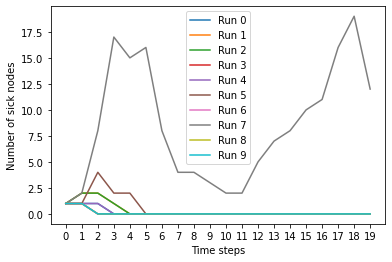

In [77]:
for i, (num_infected, num_nodes) in enumerate(all_runs):    
    plt.plot(np.array(num_infected), label='Run '+str(i))

plt.xticks(np.arange(20))
plt.xlabel('Time steps')
plt.ylabel('Number of sick nodes')
plt.legend()
# plt.savefig('./random_SIR_runs.png', bbox_inches='tight')
plt.show()

In [78]:
max_fraction = [np.round(np.array(num_infected).sum()/num_nodes, 4) for (num_infected, num_nodes) in all_runs]
print("The fraction of affected nodes for all 10 runs are:", str(max_fraction))

The fraction of affected nodes for all 10 runs are: [0.0017, 0.0033, 0.0033, 0.0011, 0.0017, 0.0055, 0.0011, 0.0939, 0.0011, 0.0011]


In [75]:
print("The mean and std of the fraction of affected nodes during epidemics is", np.mean([x for x in max_fraction if x > 0.1]), "and", np.std([x for x in max_fraction if x > 0.1]) )

The mean and std of the fraction of affected nodes during epidemics is 0.95274 and 0.0039877813380374974


##### SIR model for random graph

In [232]:
print("Critical transmissibility for random graph is ", z1/z2)

Critical transmissibility for random graph is  0.04572853339278255


In [61]:
T = 0.4
def f(hv):
    l = [float(polylog(tau-1, (1 + T*(h-1))*np.exp(-alpha) )/((1 + T*(h-1))* polylog(tau-1, np.exp(-alpha) ))) - h for h in hv]
    return l
# xvals = np.arange(1000)/1000
# yvals =  f(xvals)
# plt.plot(xvals, yvals)
# plt.plot(xvals, xvals)

guess = 0.1
sol = fsolve(f, guess)[0]
print("Numerical solution is ", sol)

Numerical solution is  0.1144001979256814


In [58]:
def G0(x):
    return float(polylog(tau, x*np.exp(-alpha) )/polylog(tau, np.exp(-alpha) ) )
print("Fraction of nodes infected in epidemic is ", 1 - G0(0.4*(sol-1) + 1))

Fraction of nodes infected in epidemic is  0.6928012707216763


In [256]:
1 - 0.0457/0.4

0.88575

In [257]:
N

7624